# CIFAR10

DOWNLOAD DATA FROM [HERE](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) AND PUT IT TO THE DATA FOLDER

The [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks. Such a situation is called **multiclass** classification in oppose to **multilabel** classification when each example may have multiple label.

One can see state-of-the-art results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

In [1]:
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

# Data

Unarchive data

In [3]:
tar = tarfile.open("data/cifar-10-python.tar.gz", "r:gz")
tar.extractall("data")
tar.close()

## Reading

Data are stored as a memory dump with python $\text{dict}$ object. It was created using **pickle** function. To read one should "unpickle" it.

In [4]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding="latin1")
    fo.close()
    return dict

Data are also splitted in to 5 pieces for conveniece. Let's read them all and concatenate

In [5]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

Read test data. In this dataset train/test split is provided by authors of the dataset to be able to consistently evaluate solutions

In [6]:
data_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

Read meta-information file with the names of the classes

In [7]:
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"]

## Pre-processing

We have too many data

In [8]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 50000
Test size: 10000


Let's take only 10% of them to train faster

In [9]:
subsample_rate = 0.1

We want to preserve the same quantity ratio between classes. In python such an option is called **stratification**. Let's randomly (with fixed initial seed for the sake of reproducibility) divide part of train data

In [10]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The same for test

In [11]:
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Indeed, we preserved the number of objects of each class

In [12]:
unique_train = np.unique(y_train, return_counts=True)
list(zip(np.array(classes)[unique_train[0]], unique_train[1]))

[('airplane', 500),
 ('automobile', 500),
 ('bird', 500),
 ('cat', 500),
 ('deer', 500),
 ('dog', 500),
 ('frog', 500),
 ('horse', 500),
 ('ship', 500),
 ('truck', 500)]

## Visualization

For now each object has the following shape

In [13]:
X_train[0].shape

(3072,)

$3072 = 32 \times 32 \times 3$ where $32 \times 32$ is the size of the image in pixels and $3$ is the number of channels (RGB)

To show this array as an image let's reshape it in the needed from with the shape $(32, 32, 1)$

In [14]:
def show_pic(x):
    plt.imshow(x.reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
    plt.axis("off")

Draw one pic from each class

In [15]:
classes_idx_examples = np.zeros(10, dtype=np.int)
for i in range(10):
    classes_idx_examples[i] = np.where(y_train == i)[0][0]

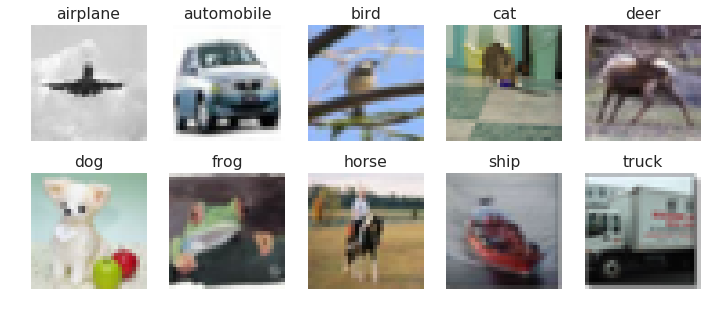

In [16]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_train[classes_idx_examples[i]])
    plt.title(classes[i])

# Sklearn Logistic Regression

Let's use Sklearn implementation of algorithms to have a benchmark.

Also one should **always** track the results of the experiments to be able to compare different approaches. Let's create pandas $\text{DataFrame}$ for this purpose.

In [17]:
results = pd.DataFrame(columns=["Model", "Test Accuracy"])

For now it is empty, but will be filled in later

In [18]:
results

,Model,Test Accuracy


## Defining model

Let's try Multinomial Logistic Regression (see theory in lectures)

Here we use Sklearn $\text{LogisticRegression}$ with few options:
* $\text{multi_class} = \text{"multinomial"} -$we want to build softmax classifier (there are other ways of dealing with multiclass setting for Logistic Regression)
* $\text{C} = 10^6-$ for now we don't want to use regularization; $\text{C}$ is the inverse regularization constant which is $\text{C} = \frac{1}{\lambda}$; thus we should make $\text{C}$ big to turn of regulazrization
* $\text{solver} = \text{sag} -$ optimization algorithm to use; Stochastic Average Gradient. Stochastic Gradient Descent method gitters massively. This is due to the not very good approximation of gradient (only by one example). To neglect this error one can simply average gradient across last few steps; that is exectly what $\text{sag}$ does
* $\text{max_iter} = 15 -$ the number of passes over the training data (aka epochs)

In [19]:
model_lr_sklearn = LogisticRegression(multi_class="multinomial", C=1e6, solver="sag", max_iter=15)

### Fitting

In [20]:
model_lr_sklearn.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=15,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

### Evaluation

Prediction

In [21]:
y_pred_test = model_lr_sklearn.predict(X_test)

Accuracy

In [22]:
acc = accuracy_score(y_test, y_pred_test)

Keeping table of results up-to-date

In [23]:
results.loc[len(results)] = ["LR Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,LR Sklearn,0.363


# Assignment

Below one can find pure python implementation of Logistic Regression. Note that here we added an ability to trace validation metrics.

In [24]:
class LogisticRegressionHomegrown(object):
    
    def __init__(self):
        """
        Constructor for the homgrown Logistic Regression
        
        Args:
            None
        
        Return:
            None
        """
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "acc": [], 
                        "val_cost":[], 
                        "val_acc": []}
        
    def _grad(self, X, y):
        """
        Calculates the gradient of the Logistic Regression 
        objective function

        Args:
            X(ndarray):    train objects
            y(ndarray):    answers for train objects
            
        Return:
            grad(ndarray): gradient
        """
        # number of training examples
        n = X.shape[0]
        
        # get scores for each class and example
        # 2D matrix
        scores = self._predict_raw(X)
        
        # transform scores to probabilities
        # softmax
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # error
        probs[range(n),y] -= 1
        
        # gradient
        gradient = np.dot(X.T, probs) / n
        
        return gradient
    
    def _gd(self, X, y, max_iter, alpha, X_val, y_val):
        """
        Runs Full GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        for i in range(max_iter):
            
            metrics = self.score(X, y)
            self.history["cost"].append(metrics["cost"])
            self.history["acc"].append(metrics["acc"])
            
            if X_val is not None:
                metrics_val = self.score(X_val, y_val)
                self.history["val_cost"].append(metrics_val["cost"])
                self.history["val_acc"].append(metrics_val["acc"])

            # calculate gradient
            grad = self._grad(X, y)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter=1000, alpha=0.05, val_data=None):
        """
        Public API to fit Logistic regression model
        
        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
            
        Return:
            None
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        if val_data is not None:
            X_val, y_val = val_data
            X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        else:
            X_val = None
            y_val = None
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1], len(np.unique(y)))
        
        # do full gradient descent
        self._gd(X, y, max_iter, alpha, X_val, y_val)
        
        # get final weigths and bias
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        
    def score(self, X, y):
        """
        Computes logloss and accuracy for (X, y)
        
        Args:
            X(ndarray):      objects
            y(ndarray):      answers for objects
            
        Return:
            metrics(dict):   python dictionary which
                             contains two fields: for accuracy 
                             and for objective function
        """
        # number of training samples
        n = X.shape[0]
        
        # get scores
        scores = self._predict_raw(X)
        
        # trasnform scores to probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # logloss per each example
        corect_logprobs = -np.log(probs[range(n),y])
        
        # total mean logloss
        data_loss = np.sum(corect_logprobs) / n
        
        # predictions
        pred = np.argmax(scores, axis=1)
        # accuracy
        acc = accuracy_score(y, pred)
        
        # final metrics
        metrics = {"acc": acc, "cost": data_loss}
        
        return metrics
        
    def _predict_raw(self, X):
        """
        Computes scores for each class and each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            scores(ndarray): scores for each class and object
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            scores = np.dot(X, self._theta)
        else:
            scores = np.dot(X, self.coef_) + self.intercept_
        return scores
    
    def predict(self, X):
        """
        Predicts class for each object in X
        
        Args:
            X(ndarray):      objects
        
        Return:
            pred(ndarray):   class for each object
        """
        # get scores for each class
        scores = self._predict_raw(X)
        # choose class with maximum score
        pred = np.argmax(scores, axis=1)
        return pred

**Do not forget** to scale data before using this class. It is crucial.

In [25]:
if np.max(X_train) > 4.:
    X_train = X_train.astype(np.float32) / 255.
if np.max(X_test) > 4.:
    X_test = X_test.astype(np.float32) / 255.

Defining a model

In [26]:
model_lr_homegrown = LogisticRegressionHomegrown()

Fitting example

In [27]:
model_lr_homegrown.fit(X_train, y_train, max_iter=10, alpha=0.05)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:138: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


And we come up with all the $\text{nan's}$ for objective function

In [28]:
model_lr_homegrown.history["cost"]

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

And accuracy also does not change

In [29]:
model_lr_homegrown.history["acc"]

[0.1188,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.10000000000000001]

## Task 1
What can lead to such kind of results? (Hint: see the lecture on softmax)
* Fix it

In [ ]:
class FixedLogisticRegressionHomegrown(LogisticRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(FixedLogisticRegressionHomegrown, self).__init__()
        
    #==================================================#
    #               Place your code here               #
    #     Redefine a method which causes the error     #
    #               Hint: only one method              #
    #==================================================#

Defining a model

In [ ]:
model_lr_homegrown_fixed = FixedLogisticRegressionHomegrown()

Fitting example

In [ ]:
model_lr_homegrown_fixed.fit(X_train, y_train, max_iter=2000, alpha=0.05, val_data=(X_test, y_test))

In [ ]:
plt.figure(figsize=(20, 8))
plt.suptitle("Homegrown Logistic Regression")
plt.subplot(121)
plt.plot(model_lr_homegrown_fixed.history["cost"], label="Train")
plt.plot(model_lr_homegrown_fixed.history["val_cost"], label="Test")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.subplot(122)
plt.plot(model_lr_homegrown_fixed.history["acc"], label="Train")
plt.plot(model_lr_homegrown_fixed.history["val_acc"], label="Test")
plt.legend(loc="upper left")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

Prediction

In [ ]:
y_pred_test = model_lr_homegrown_fixed.predict(X_test)

Accuracy

In [ ]:
acc = accuracy_score(y_test, y_pred_test)

Keeping table of results up-to-date

In [ ]:
results.loc[len(results)] = ["LR Homegrown Fix 1", np.round(acc, 3)]
results

## Task 2
Look at the plots obtained at the end of task 1 (it should fluctuates a lot). This behaviour is mainly inherent to stochastic gradient descent. But here we did full GD. With which reason can it also be connected? (*Hint*: was discussed at class)
* Describe what's going on on the plots that you got
* Try to fix it (*Hint*: you do not need to change the class implemented before)

P.S.
Test accuracy before this fix should be about 26% and 31% after. Thus it is easy yet effective fix

In [ ]:
#==================================================#
#               Place your code here               #
#==================================================#

** Note: I was able to get about 31% test set accuracy with all the fixes and tunes**

## Task 3
Display the  weight vectors (like images) for each class for both Sklearn model and best homegrown model. Can you see any class patterns?

In [ ]:
#==================================================#
#               Place your code here               #
#   Hint: use show_pic() function defined above    #
#==================================================#

## T-SNE dimensionality reduction.

See [this](https://www.dropbox.com/s/q0lrqtphxh5j4uv/6-Mapping_Representations-tSNE-visualize-DL-Model-Layers.ipynb?dl=0) notebook and also search materials on the internet (e.g. [this](http://distill.pub/2016/misread-tsne/) one) on T-SNE (t-Distributed Stochastic Neighbor Embedding).

Perform this embedding (there is [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementation) on first three classes and 500 examples per each of them (this is done ro reduce the execution time)